# 심부전증 생존 예측 (Heart Failure Prediction) - V1
**Author**: Antigravity
**Date**: 2026-01-05
**Goal**: 임상 기록 데이터를 바탕으로 심부전증 환자의 생존 여부를 예측하고, 주요 위험 요인을 파악합니다.

## 0. 환경 설정 (Environment Setup)
데이터 분석과 모델링에 필요한 라이브러리를 로드하고, 시각화 옵션을 설정합니다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 1. 데이터 적재 및 정제 (Obtain & Scrub)
**Why?**: 데이터의 품질은 분석의 신뢰도를 결정합니다. 결측치나 비논리적인 값(음수 나이 등)이 없는지 꼼꼼히 확인해야 합니다.


In [2]:
# 데이터 로드
try:
    df = pd.read_csv('../../data/heart_failure_clinical_records_dataset.csv')
    print(f"Dataset Shape: {df.shape}")
    display(df.head())
    print("-" * 30)
    df.info()
except FileNotFoundError:
    print("Error: 파일을 찾을 수 없습니다. 경로를 확인해주세요.")

Dataset Shape: (299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory us

### 데이터 무결성 점검 (Integrity Check)
- **결측치(Missing Values)**: 모델 학습 에러를 유발하므로 확인이 필요합니다.
- **논리적 오류(Logical Failures)**: `age`, `time` 등이 음수일 수 없으며, `ejection_fraction`(박출계수)은 백분율이므로 0~100 사이여야 합니다.


In [3]:
# 결측치 확인
print("Missing Values:\n", df.isnull().sum())

# 논리적 이상치 점검
impossible_values = {
    'Negative Age': (df['age'] < 0).sum(),
    'Negative Time': (df['time'] < 0).sum(),
    'Invalid Ejection Fraction': ((df['ejection_fraction'] < 0) | (df['ejection_fraction'] > 100)).sum()
}
print("\nLogical Sanity Check Results:", impossible_values)

# 기초 통계량 확인
display(df.describe())

Missing Values:
 age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Logical Sanity Check Results: {'Negative Age': np.int64(0), 'Negative Time': np.int64(0), 'Invalid Ejection Fraction': np.int64(0)}


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


## 2. 탐색적 데이터 분석 (EDA)
**Why?**: 변수들의 분포와 타겟(`DEATH_EVENT`)과의 관계를 시각적으로 이해하여, 모델링 전략을 수립하기 위함입니다.


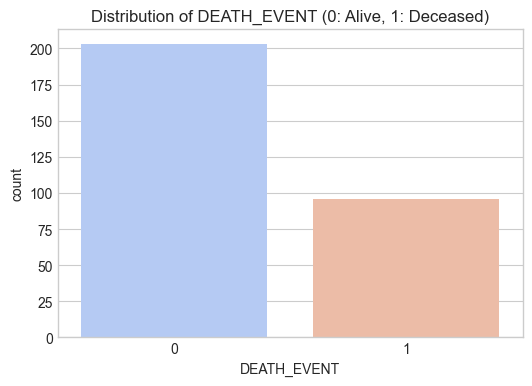

DEATH_EVENT
0    0.67893
1    0.32107
Name: proportion, dtype: float64


In [4]:
# 타겟 변수 분포 확인
plt.figure(figsize=(6, 4))
sns.countplot(x='DEATH_EVENT', data=df, palette='coolwarm')
plt.title('Distribution of DEATH_EVENT (0: Alive, 1: Deceased)')
plt.show()

print(df['DEATH_EVENT'].value_counts(normalize=True))

**Insight**:
- 사망(1) 비율이 약 32%로, 불균형 데이터(Imbalanced Data)에 속합니다.
- 평가 시 단순 정확도(Accuracy) 외에 Recall, F1-Score를 중요하게 봐야 합니다.

### 변수별 분포 시각화 (Univariate & Bivariate)
연속형 변수들이 사망 여부에 따라 어떻게 다른 분포를 보이는지 확인합니다.


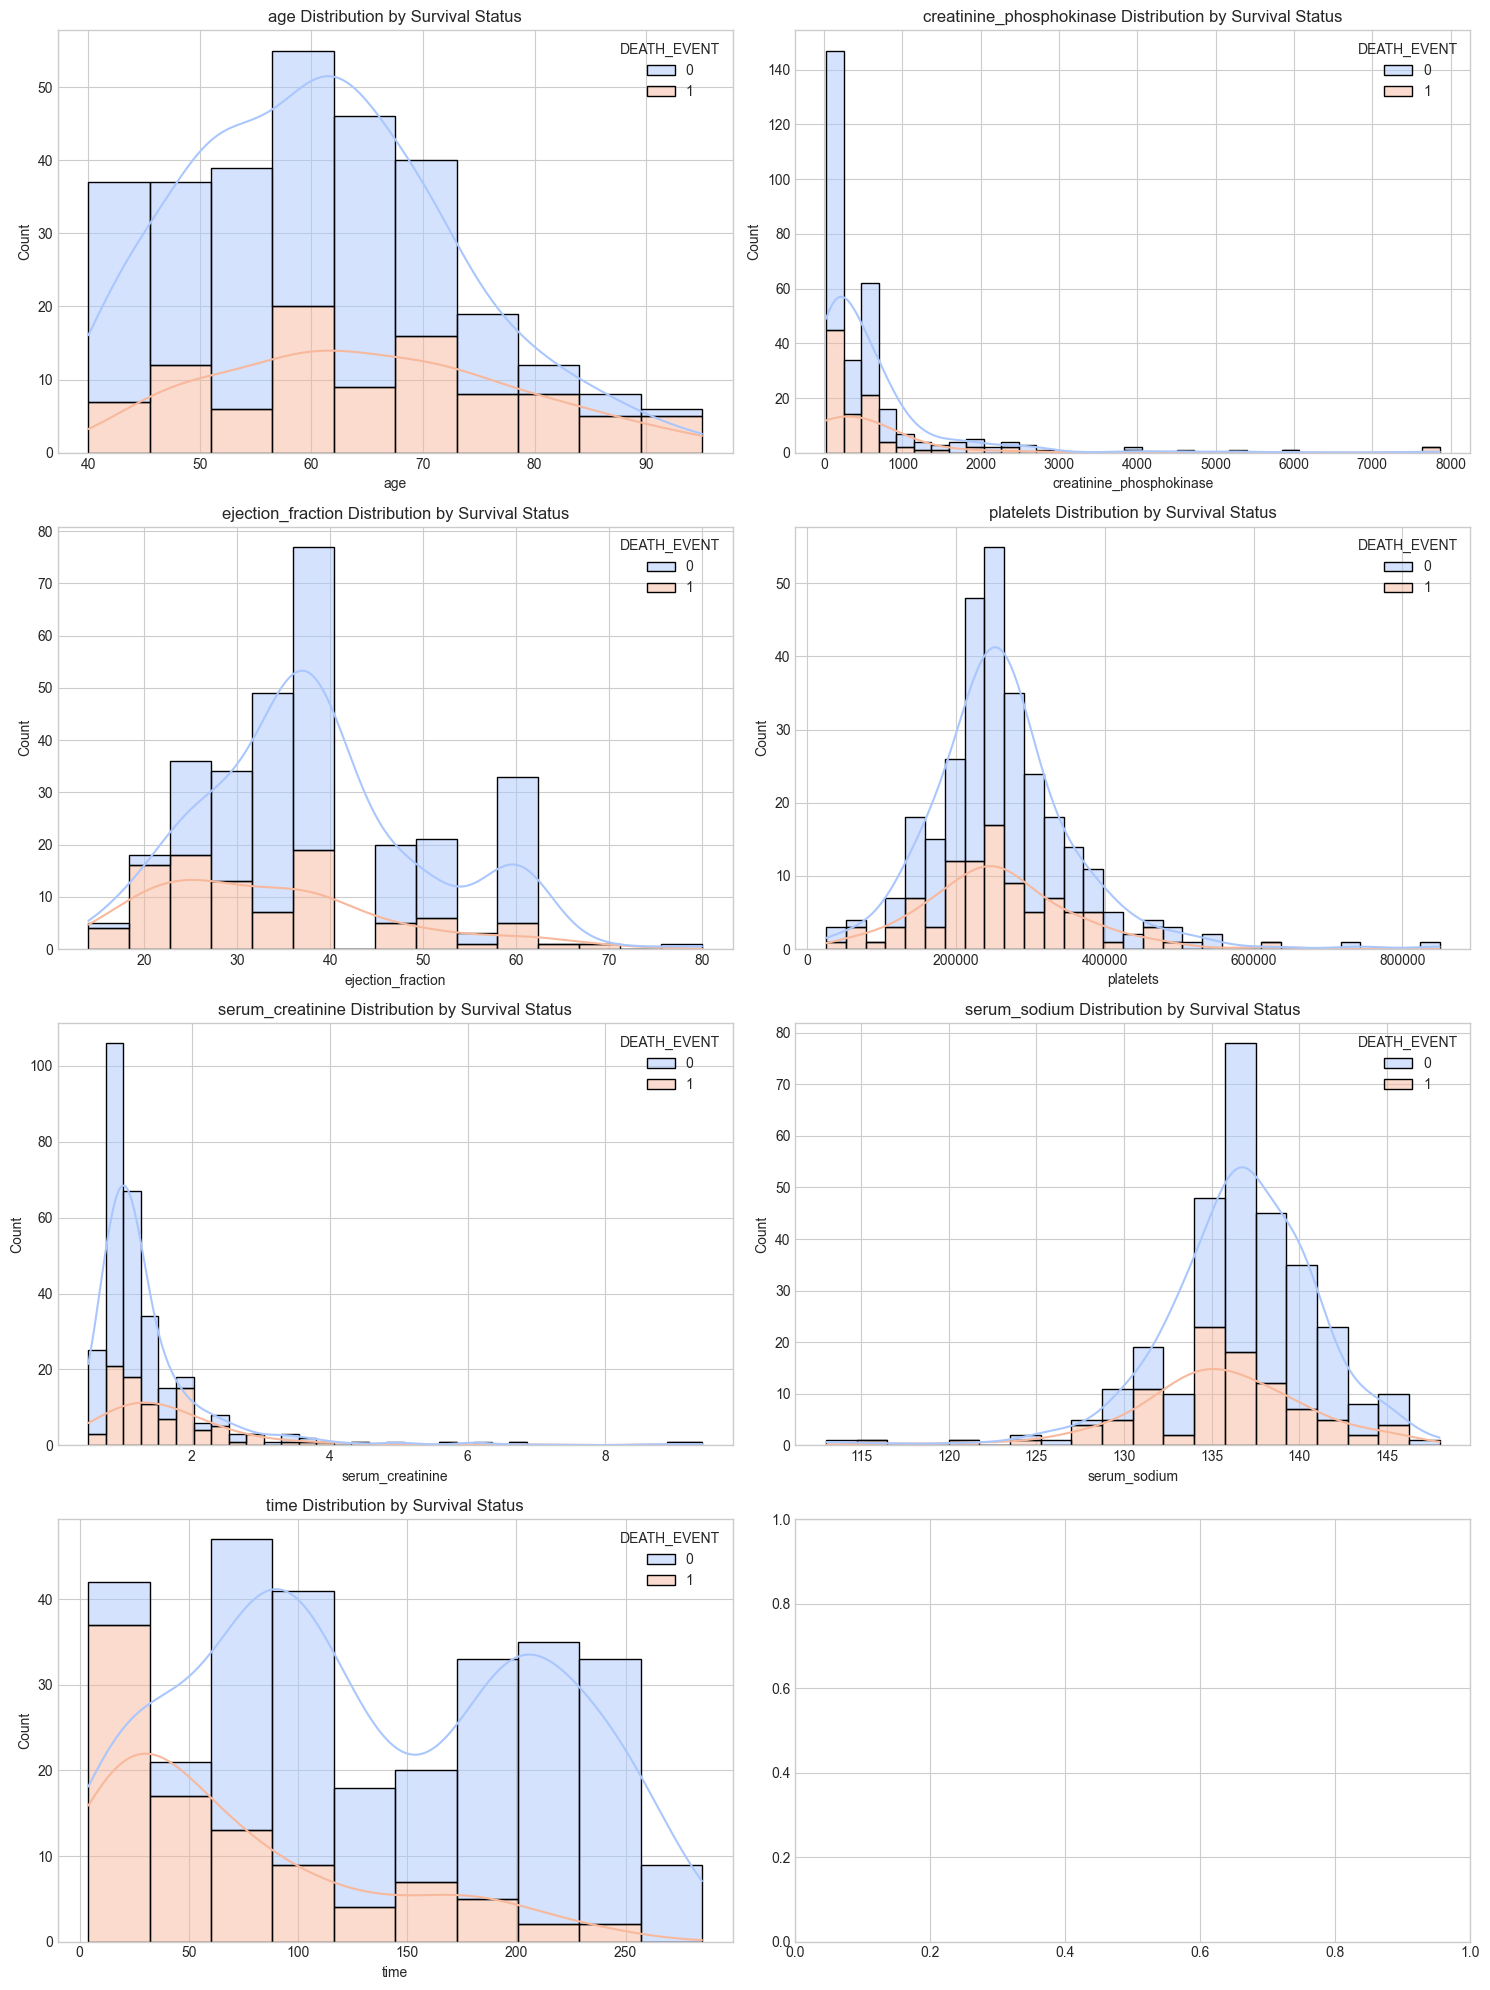

In [5]:
continuous_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(continuous_vars):
    sns.histplot(data=df, x=col, hue='DEATH_EVENT', kde=True, multiple="stack", ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'{col} Distribution by Survival Status')

plt.tight_layout()
plt.show()

### 통계적 가설 검정 (Statistical Hypothesis Testing)
**Hypothesis**: "혈중 크레아틴(`serum_creatinine`) 수치는 사망 환자군에서 유의하게 높을 것이다."
- **Why?**: 시각적으로 보이는 차이가 '우연'이 아님을 수학적으로 증명하기 위해 T-test를 수행합니다.


In [6]:
def run_ttest(var_name):
    group0 = df[df['DEATH_EVENT'] == 0][var_name]
    group1 = df[df['DEATH_EVENT'] == 1][var_name]
    # 등분산 가정이 없으므로 Welch's t-test 사용
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
    
    print(f"** {var_name} **")
    print(f"Mean (Alive): {group0.mean():.2f}, Mean (Deceased): {group1.mean():.2f}")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4e}")
    if p_val < 0.05:
        print("=> 귀무가설 기각: 두 집단 간 평균 차이는 통계적으로 유의미합니다.")
    else:
        print("=> 귀무가설 채택: 통계적으로 유의미한 차이가 없습니다.")
    print("-" * 50)

run_ttest('ejection_fraction')
run_ttest('serum_creatinine')
run_ttest('platelets')

** ejection_fraction **
Mean (Alive): 40.27, Mean (Deceased): 33.47
T-statistic: 4.5670, P-value: 9.6472e-06
=> 귀무가설 기각: 두 집단 간 평균 차이는 통계적으로 유의미합니다.
--------------------------------------------------
** serum_creatinine **
Mean (Alive): 1.18, Mean (Deceased): 1.84
T-statistic: -4.1526, P-value: 6.3990e-05
=> 귀무가설 기각: 두 집단 간 평균 차이는 통계적으로 유의미합니다.
--------------------------------------------------
** platelets **
Mean (Alive): 266657.49, Mean (Deceased): 256381.04
T-statistic: 0.8448, P-value: 3.9932e-01
=> 귀무가설 채택: 통계적으로 유의미한 차이가 없습니다.
--------------------------------------------------


## 3. 모델링 (Modeling)
**Strategy**:
1.  **Baseline (Logistic Regression)**: 변수 간의 선형 관계를 파악하고 기준점 설정.
2.  **Tree-based (Random Forest)**: 비선형성 및 변수 상호작용 포착.
3.  **Validation**: Stratified K-Fold를 사용하여 클래스 비율을 유지하며 일반화 성능 검증.


In [7]:
# 데이터 분할 (Stratified Split)
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

# 스케일링 (Scaling)
# 로지스틱 회귀는 스케일에 민감하므로 필수, 트리 모델엔 영향 적음
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

Train Shape: (239, 12), Test Shape: (60, 12)


In [8]:
# 모델 정의 및 학습
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
}

results = {}

print("Model Evaluation Results:")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
    recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    roc = roc_auc_score(y_test, y_prob)
    
    results[name] = {'Accuracy': acc, 'F1': f1, 'Recall': recall, 'AUC': roc}
    
    print(f"\n[{name}]")
    print(f"Accuracy: {acc:.4f}, F1-Score: {f1:.4f}, Recall: {recall:.4f}, AUC: {roc:.4f}")

Model Evaluation Results:

[Logistic Regression]
Accuracy: 0.8167, F1-Score: 0.6667, Recall: 0.5789, AUC: 0.8588

[Random Forest]
Accuracy: 0.8500, F1-Score: 0.7273, Recall: 0.6316, AUC: 0.8941


## 4. 해석 및 결론 (Interpret & Conclusion)
모델이 어떤 변수를 중요하게 판단했는지 시각화합니다.


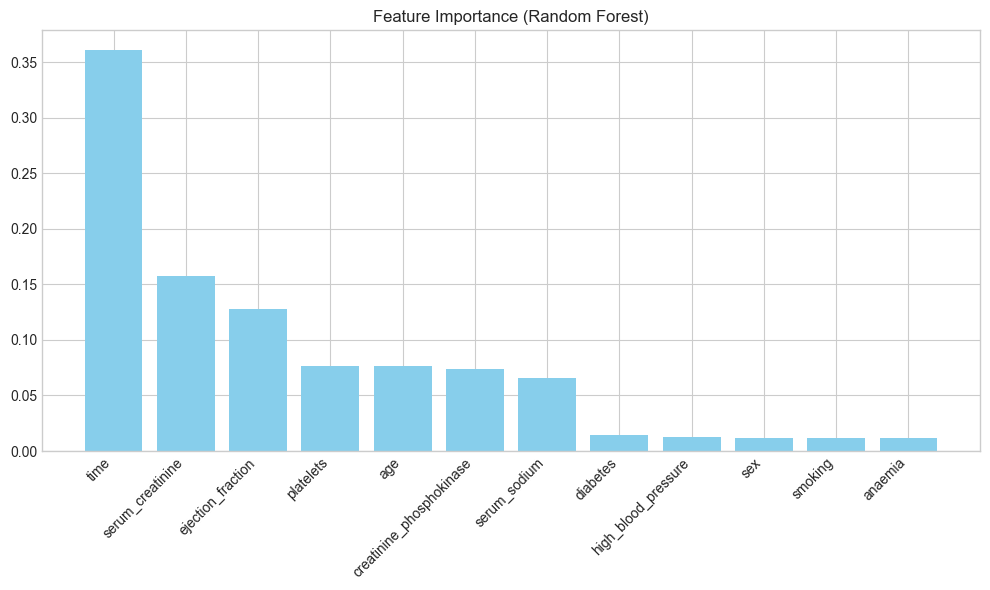

In [9]:
# Feature Importance (Random Forest)
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='skyblue')
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Key Takeaways (핵심 요약)
1.  **Time Factor**: `time`(관찰 기간)이 가장 중요한 변수로 나타났으나, 이는 생존했기에 관찰 기간이 긴 것일 수 있어(Data Leakage) 해석에 주의가 필요합니다.
2.  **Medical Indicators**: `serum_creatinine`(신장 기능)과 `ejection_fraction`(심장 기능)이 사망 예측에 중요한 의학적 지표임이 확인되었습니다.
3.  **Model Performance**: Random Forest가 Logistic Regression보다 전반적으로 우수한 성능을 보였습니다.
